# Clustering

In [58]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import mglearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons,make_blobs,fetch_lfw_people
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import adjusted_rand_score,silhouette_score,silhouette_samples
from numpy.random import multivariate_normal

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
def discrete_cs_scatter(x1,x2,cols,shapes,axis=None):
    available_shapes=['o','v','^','<','>']
    available_cols=['red','green','blue','gray']
    if axis == None:
        axis = plt.gca()
    for _x1,_x2,col,sh in zip(x1,x2,cols,shapes):
        axis.scatter(_x1,_x2,c=available_cols[col],marker=available_shapes[sh])
        
def sample_2d_gaussian(mean,covar,numsamps):
    '''
    Generates a random sample of size 'numsamps' from a 2-dimensional Gaussian distribution.
    The Gaussian is defined by the mean vector mean=[meanx,meany] and the 
    covariance matrix covar=[variance_x,variance_y,covariance]:
    
    variance_x    covariance
    covariance    variance_y
    
    All parameters can be freely chosen, except covariance, which must satisfy the inequality
    
    covariance <= sqrt(variance_x * variance_y)
    '''
    covarmatrix = np.array([[covar[0],covar[2]],[covar[2],covar[1]]])
    return multivariate_normal(mean,covarmatrix,numsamps)    

def sample_mix2d_gaussians(size,mixcoeff,means,covars):
    '''
    size: integer. Total number of points to be sampled
    mixcoeff: array of float.  Specifies number and relative sizes of mixture components
    means: array of shape [len(mixcoeff),2] specifying the mean vectors for each component
    covars: array of shape [len(mixcoeff),3] specifying the covariance matrix for each component
    '''
    mixcoeff=mixcoeff/np.sum(mixcoeff)
    componentsizes=(size*mixcoeff).astype(int)
    size=np.sum(componentsizes) #Could be different from original size param, due to rounding, 
                                #or because mixcoeff do not sum to 1
    
    X=np.zeros([size,2])
    Y=np.zeros(size)
    
    nextidx = 0
    
    for i in np.arange(len(mixcoeff)):
        X[nextidx:nextidx+componentsizes[i],:]=sample_2d_gaussian(means[i,:],covars[i,:],componentsizes[i])
        Y[nextidx:nextidx+componentsizes[i]]=i
        nextidx=nextidx+componentsizes[i]
    return X,Y  

### Part 1

We are creating some random blob data. Note that the class labels that are also generated and shown in the plots are not used in clustering

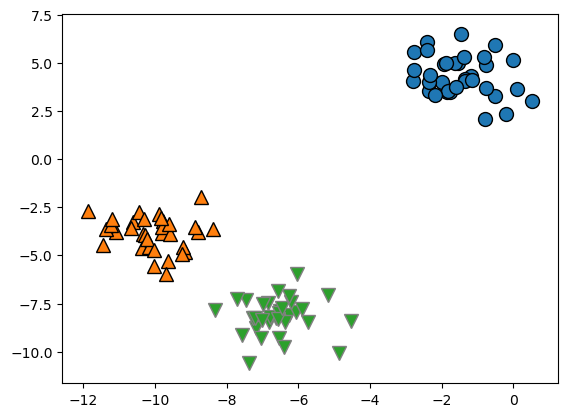

In [3]:
X,y=make_blobs(n_features=2, centers=3,random_state=1)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.show()

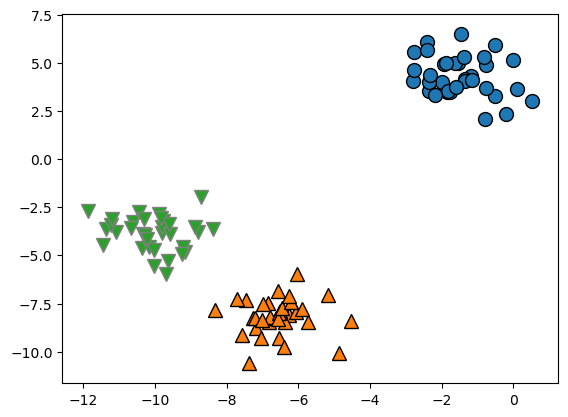

In [4]:
kmeansclus = KMeans(n_clusters=3,n_init=1).fit(X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeansclus.labels_)
plt.show()

Varying the number of clusters:

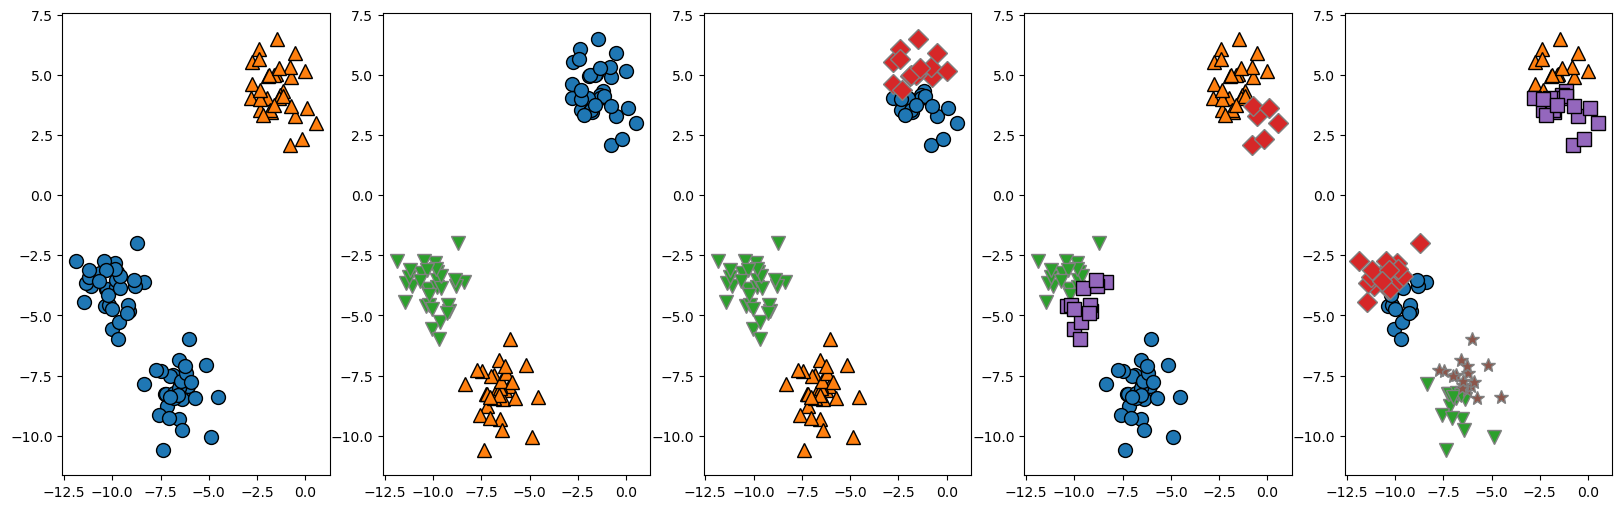

In [5]:
nclus=(2,3,4,5,6)
fig,axes = plt.subplots(1,5,figsize=(20,6))
for n,cax in zip(nclus,axes):
    kmeansclus = KMeans(n_clusters=n,n_init=1).fit(X)
    mglearn.discrete_scatter(X[:,0],X[:,1],kmeansclus.labels_,ax=cax)

The k-means algorithm will produce k clusters -- no matter whether there are k clusters in the data or not!<br>

Now let's add an outlier:

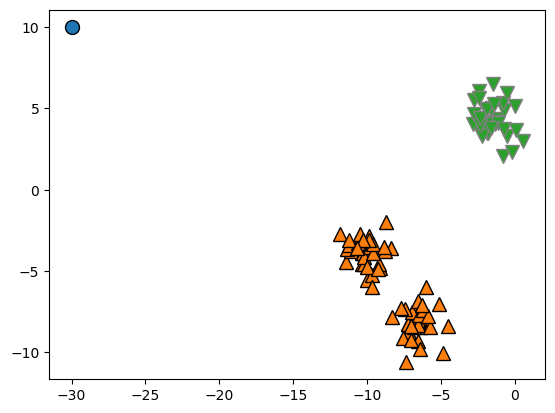

In [6]:
Xout = np.vstack([X,[-30,10]])
kmeansclus = KMeans(n_clusters=3,n_init=1).fit(Xout)
mglearn.discrete_scatter(Xout[:,0],Xout[:,1],kmeansclus.labels_)
plt.show()

Outliers can spoil the clustering result. On the other hand, we can investigate single point (or very small) clusters, and possibly remove them as outliers. 

What if the "true" clusters are overlapping?

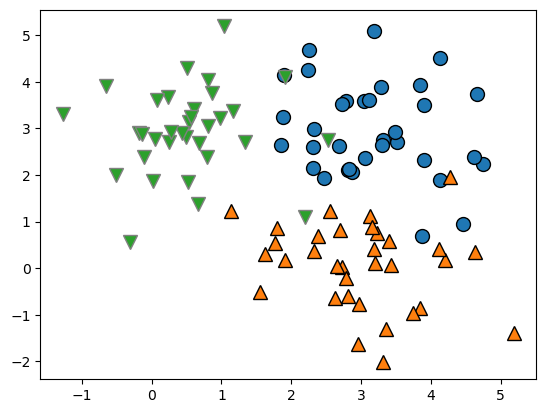

In [7]:
sep=3
X,y=make_blobs(n_features=2, centers=np.array([[sep,sep],[sep,0],[0,sep]]),random_state=1)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.show()

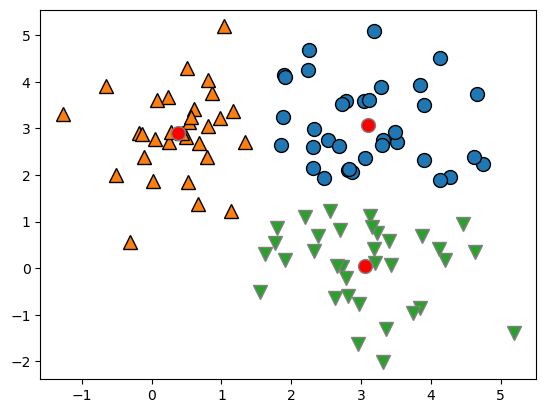

In [8]:
kmeansclus = KMeans(n_clusters=3,n_init=1).fit(X)
mglearn.discrete_scatter(X[:,0],X[:,1],kmeansclus.labels_)
C=kmeansclus.cluster_centers_
mglearn.discrete_scatter(C[:,0],C[:,1],c='red')

plt.show()

Non spherical clusters. The following is similar to the `make_blobs` data generator, but it has additional parameters that allow us to generate elongated and tilted blobs.

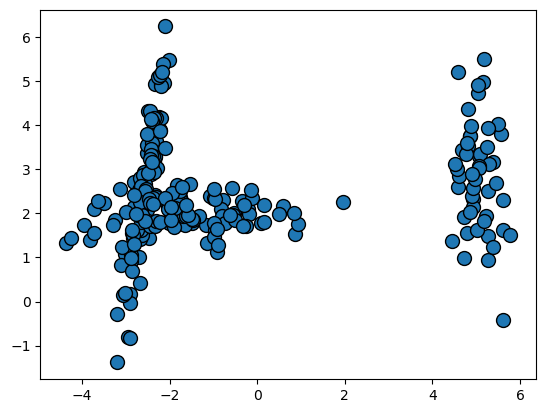

In [9]:
means=np.array([[-2.5,3],[5,3],[-1.5,2]])
covars=np.array([[0.1,3.0,0.5],[0.1,1.5,0],[1.3,0.1,0]])
mixturecoeff=np.array([0.4,0.2,0.4])

np.random.seed(1)
GaussMix_data, GaussMix_label = sample_mix2d_gaussians(250,mixturecoeff,means,covars)
mglearn.discrete_scatter(GaussMix_data[:,0],GaussMix_data[:,1])
plt.show()

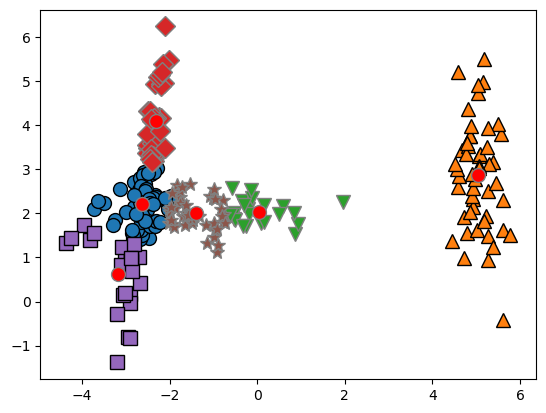

In [10]:
kmeansclus = KMeans(n_clusters=6,n_init=1).fit(GaussMix_data)
C=kmeansclus.cluster_centers_
mglearn.discrete_scatter(GaussMix_data[:,0],GaussMix_data[:,1],kmeansclus.labels_)
mglearn.discrete_scatter(C[:,0],C[:,1],c='red')

plt.show()

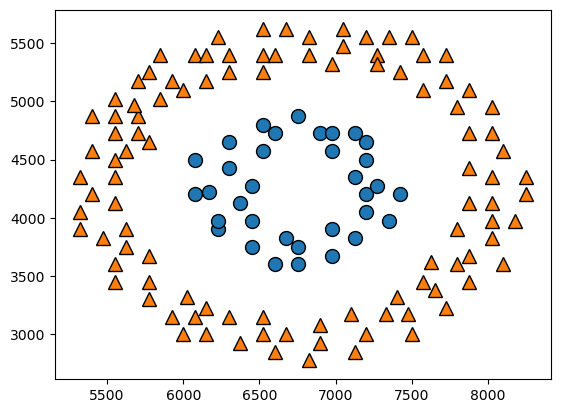

In [13]:
conc = pd.read_csv("concentric_classes.txt",sep=',')
conc_data=conc.drop(['Class'],axis=1)
conc_class=conc['Class']
mglearn.discrete_scatter(conc['X1'],conc['X2'],conc['Class'])
plt.show()

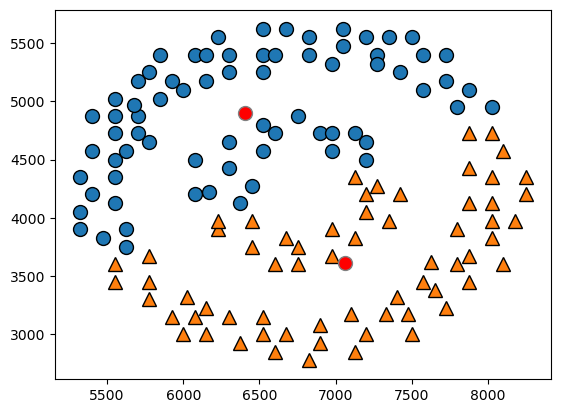

In [14]:
kmeansclus = KMeans(n_clusters=2,n_init=1).fit(conc_data)
mglearn.discrete_scatter(conc['X1'],conc['X2'],kmeansclus.labels_)
C=kmeansclus.cluster_centers_
mglearn.discrete_scatter(C[:,0],C[:,1],c='red')

plt.show()

**Exercise:** Using the code template below, create further examples of mixtures of 3 Gaussians. Try to generate examples with the following properties: 

<ul>
<li> The three mixture components correspond to visually clearly identifiable clusters, and k-means identifies them as clusters 
    </li>
    <li>
        The three mixture components correspond to visually clearly identifiable clusters, but k-means identifies very different subsets as clusters 
    </li>
    <li>
        The three mixture components do not correspond to visually clearly identifiable clusters, and k-means identifies very different subsets as clusters 
    </li>
</ul>

You can vary the data by:

<ul>
    <li>
        Modifying the number of datapoints via `datasize`, and varying the relative sizes of the mixture components by varying `mixturecoeff`
    </li>
    <li>
        Modifying the parameters of each mixture component `sample_2d_gaussian(mx,my,sx,sy,cov,componentsizes[i])' where `mx,my` specify x and y coordinate of the mean, `sx,xy` specify the variance in the x and y dimension, and 
        `cov` defines the covariance (dependence between x and y coordinate).
    </li>
    </ul>

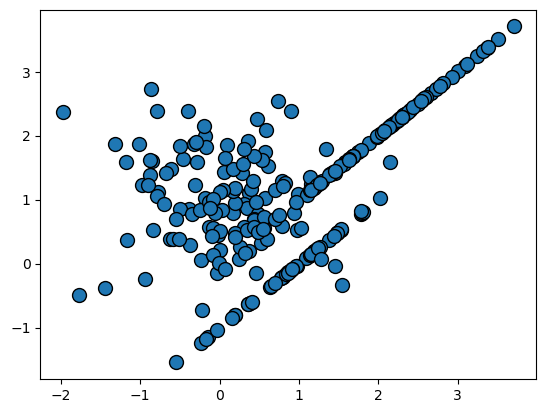

In [19]:
# set the parameters for the data distribution here
# See the explanations for these parameters in the definitions of sample_2d_gaussian and sample_mix2d_gaussians
means=np.array([[1,0],[0,1],[2,2]])
covars=np.array([[0.5,0.5,0.5],[0.5,0.5,0],[0.5,0.5,0.5]])
mixturecoeff=np.array([0.2,0.5,0.3])

np.random.seed(1)
GaussMix_data, GaussMix_label = sample_mix2d_gaussians(250,mixturecoeff,means,covars)
mglearn.discrete_scatter(GaussMix_data[:,0],GaussMix_data[:,1])
plt.show()

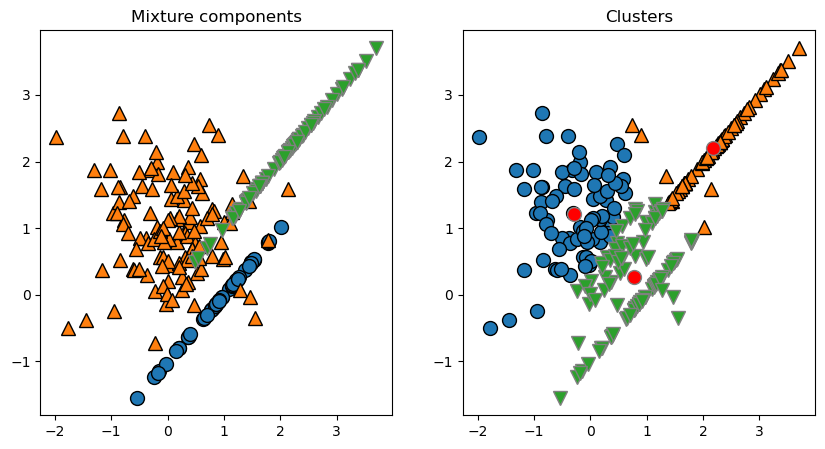

In [20]:
kmeansclus = KMeans(n_clusters=3,n_init=1).fit(GaussMix_data)
C=kmeansclus.cluster_centers_

fig,axes = plt.subplots(1,2,figsize=(10,5))

mglearn.discrete_scatter(GaussMix_data[:,0],GaussMix_data[:,1],GaussMix_label,ax=axes[0])
mglearn.discrete_scatter(GaussMix_data[:,0],GaussMix_data[:,1],kmeansclus.labels_,ax=axes[1])
mglearn.discrete_scatter(C[:,0],C[:,1],c='red',ax=axes[1])

axes[0].set_title('Mixture components')
axes[1].set_title('Clusters')

plt.show()

### Part 2

#### Faces

We get the the <a href="http://vis-www.cs.umass.edu/lfw/">Labeled Faces in the Wild</a> dataset. Insert the path for your data directory.

In [21]:
people = fetch_lfw_people(data_home='/home/jaeger/Data')

In [22]:
print('Total number of pictures: {}'.format(people.images.shape[0]))
print('Resolution: {}x{} pixels'.format(people.images.shape[1],people.images.shape[2]))
print('Shape of people.data: {}'.format(people.data.shape))

Total number of pictures: 13233
Resolution: 62x47 pixels
Shape of people.data: (13233, 2914)


Displaying image and name with specific index:

Steve Shiver


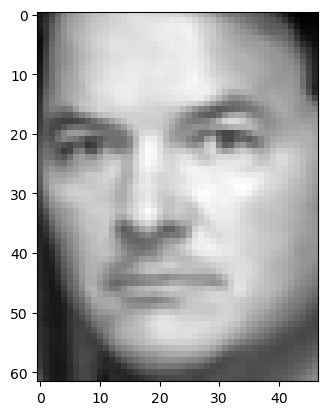

In [23]:
idx=10
plt.imshow(people.images[idx],cmap='gray')
print(people.target_names[people.target[idx]])

Finding all indices of pictures belonging to a certain person using `np.where`:

In [24]:
personname = 'Hugo Chavez'
personindex = np.where(people.target_names=='Hugo Chavez')[0]
print('{} has index {}'.format(personname,personindex))

alloccurrences=np.where(people.target==personindex)[0]

print('Pictures of {}:\n{}'.format(personname,alloccurrences))

Hugo Chavez has index [2175]
Pictures of Hugo Chavez:
[   80    98   124   146   429   638   663   764   832  1125  1282  1465
  1504  1513  1696  2450  2533  2727  2781  3027  3144  3149  3357  3436
  3681  3784  4027  4240  4301  4338  4490  4805  5072  5313  5409  5479
  5608  5754  6045  6081  6086  6099  6149  6184  6301  6538  6572  7607
  7627  8154  8263  8874  9380  9458  9545 10054 10331 10526 10579 11240
 11382 11411 11421 11477 11607 12003 12138 12453 12537 12643 13230]


Clustering using k-means (this may take a couple of minutes):

In [25]:
k=100 # use a multiple of 5
kmeansclus = KMeans(n_clusters=k,n_init=1).fit(people.data)

Plotting the cluster centers:

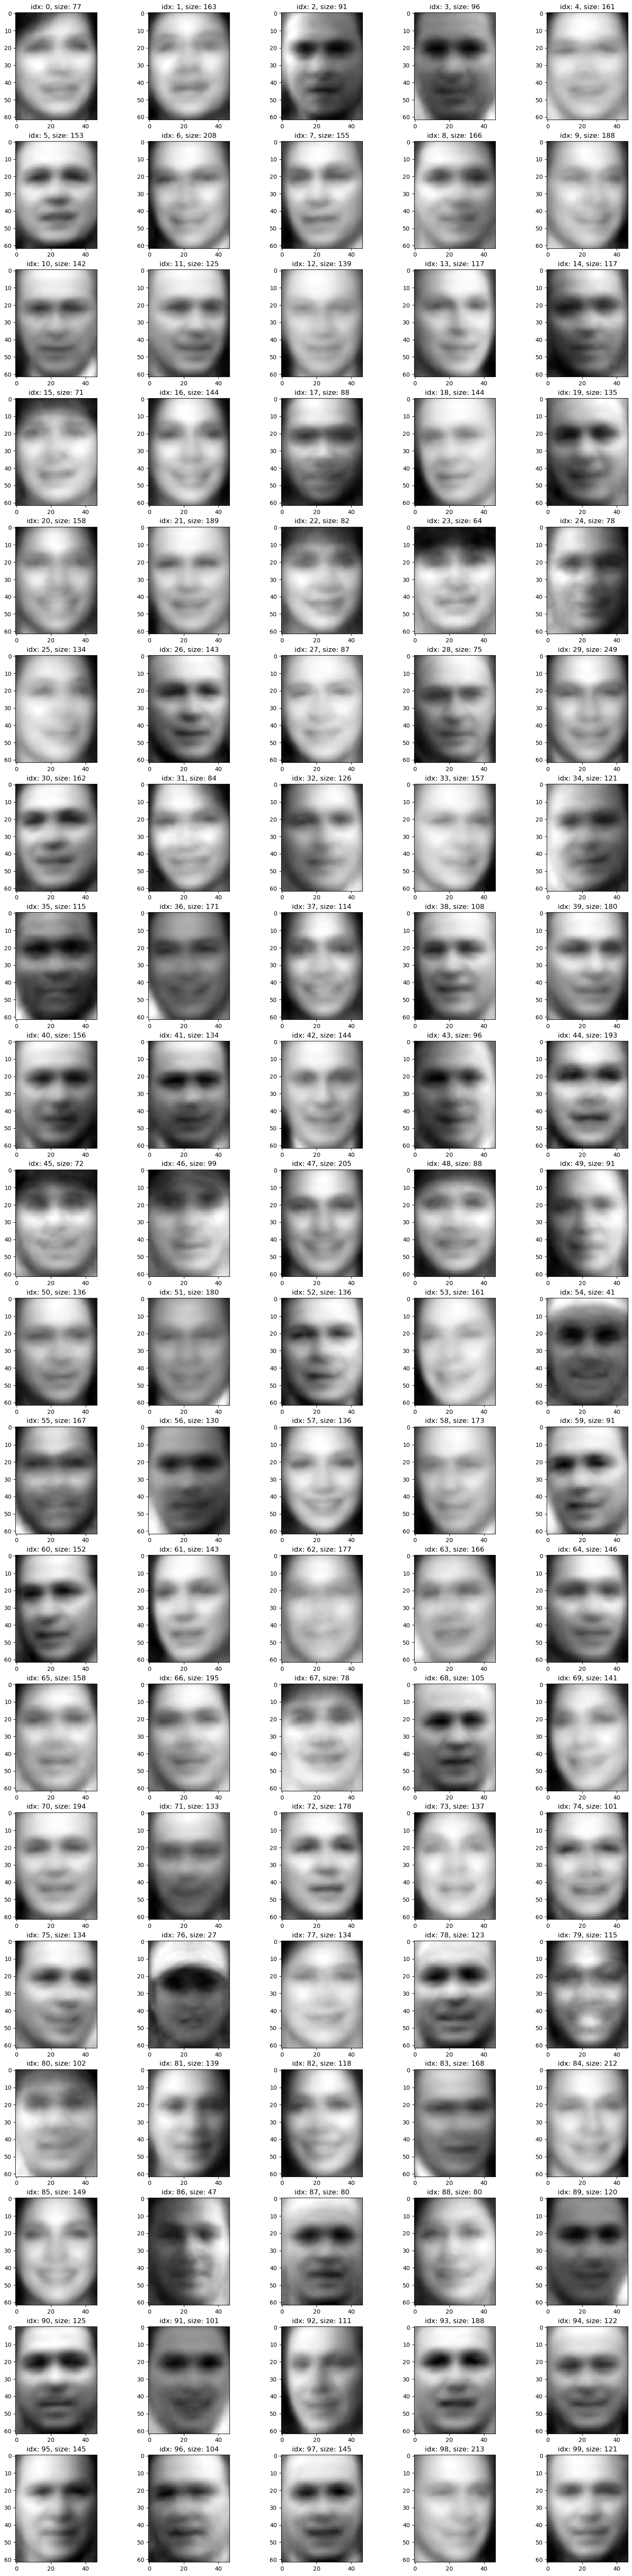

In [26]:
rows=int(k/5)
fig,axes = plt.subplots(rows,5,figsize=(20,4*rows))
for ax,cc,i in zip (axes.ravel(),kmeansclus.cluster_centers_,np.arange(axes.ravel().size)):
    ax.set_title("idx: {}, size: {}".format(i,len(np.where(kmeansclus.labels_==i)[0])))
    ax.imshow(cc.reshape(people.images[0].shape),cmap='gray')
plt.show()    
#plt.imshow(kmeansclus.cluster_centers_[0].reshape(people.images[0].shape),cmap='gray')

We find in each cluster the actual image that is closest to the cluster center, and use it as a proxy for the true cluster medoid. This is facillitated by the `transform` function, that returns for any datapoint the distance vector to all cluster centers.

The variable `pseudo_medoids` contains the indices of the images closest to the cluster centers. We then plot these images.

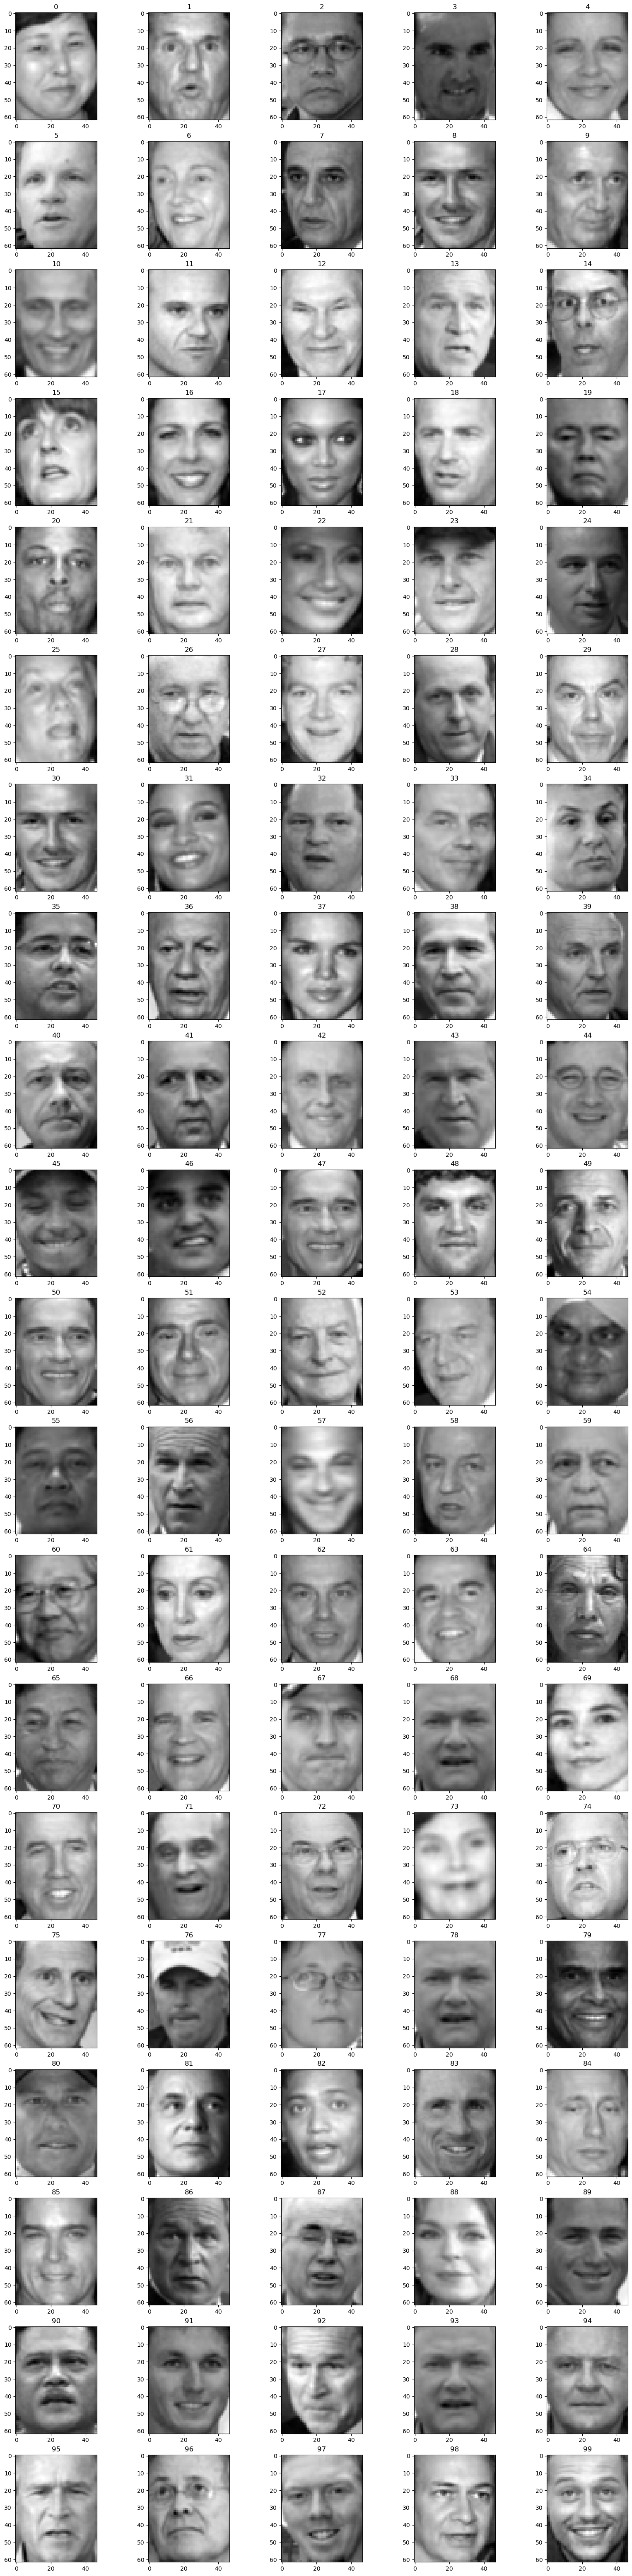

In [27]:
distances=kmeansclus.transform(people.data)
pseudo_medoids=np.argmin(distances,axis=0)

fig,axes = plt.subplots(rows,5,figsize=(20,4*rows))
for ax,pm,i in zip (axes.ravel(),pseudo_medoids,np.arange(axes.ravel().size)):
    ax.set_title(i)
    ax.imshow(people.images[pm],cmap='gray')
plt.show()    

Points to remember: to understand the output of a clustering algorithm, one has to understand what *similarity* in the sense of the underlying distance measure means.  

For the lfw image data with Euclidean distance: similarity is more determined by similar pose and lighting conditions, than by showing the same person. 

### Part 3: Hierarchical Clustering

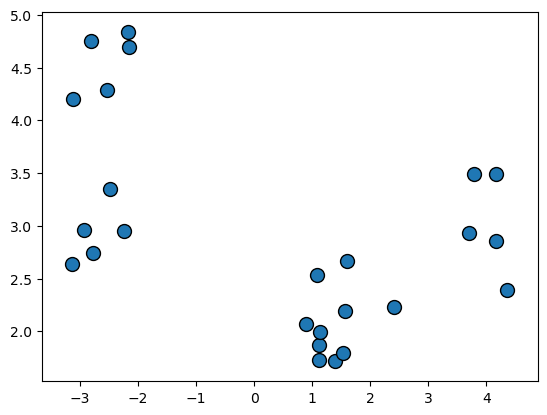

In [28]:
means=np.array([[-2.5,3],[4,3],[1.5,2]])
covars=np.array([[0.3,1.0,0.3],[0.1,0.3,0],[.3,0.1,0]])
mixturecoeff=np.array([0.4,0.2,0.4])

np.random.seed(1)
X,y = sample_mix2d_gaussians(25,mixturecoeff,means,covars)

mglearn.discrete_scatter(X[:,0],X[:,1])
plt.show()

In sklearn, there is the AgglomerativeClustering class we can use. It takes as an argument an `n_clusters` parameter, which determines at which level of clustering the agglomerative clustering ends. 

One can use AgglomerativeClustering to just produce a single clustering with `n_clusters` clusters:



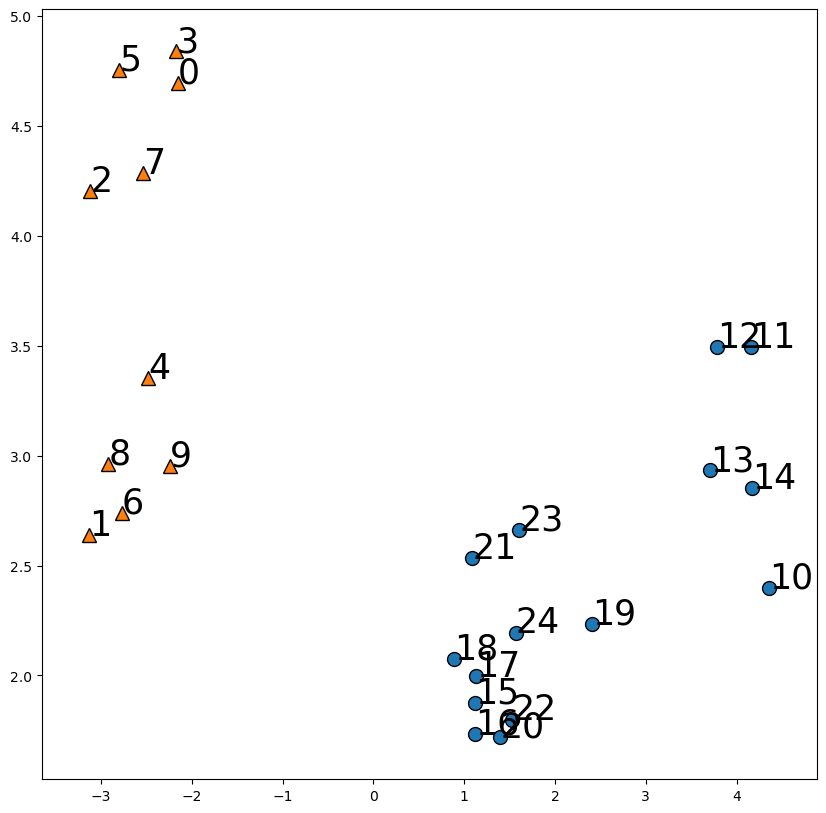

In [29]:
plt.figure(figsize=(10,10))
aggclus = AgglomerativeClustering(n_clusters=2,linkage='ward').fit(X)
mglearn.discrete_scatter(X[:,0],X[:,1],aggclus.labels_)
for i in np.arange(0,X.shape[0]):
    plt.annotate(i,(X[i,0],X[i,1]),fontsize=25)
    
plt.show()

We can also retrieve the hierarchical structure of the clustering from the `children_` attribute:

In [30]:
print(aggclus.children_)

[[15 17]
 [ 0  3]
 [20 22]
 [16 25]
 [ 6  8]
 [11 12]
 [18 28]
 [ 1 29]
 [ 4  9]
 [13 14]
 [23 24]
 [ 5  7]
 [21 35]
 [ 2 36]
 [27 31]
 [10 34]
 [32 33]
 [26 38]
 [30 40]
 [19 37]
 [39 44]
 [41 42]
 [43 45]
 [46 47]]


Unfortunately, this is not totally readable, and not easily transformed into a dendrogram. We therefore take refuge to `scipy` for doing our clustering

In [31]:
from scipy.cluster.hierarchy import dendrogram,ward,single,average,fcluster

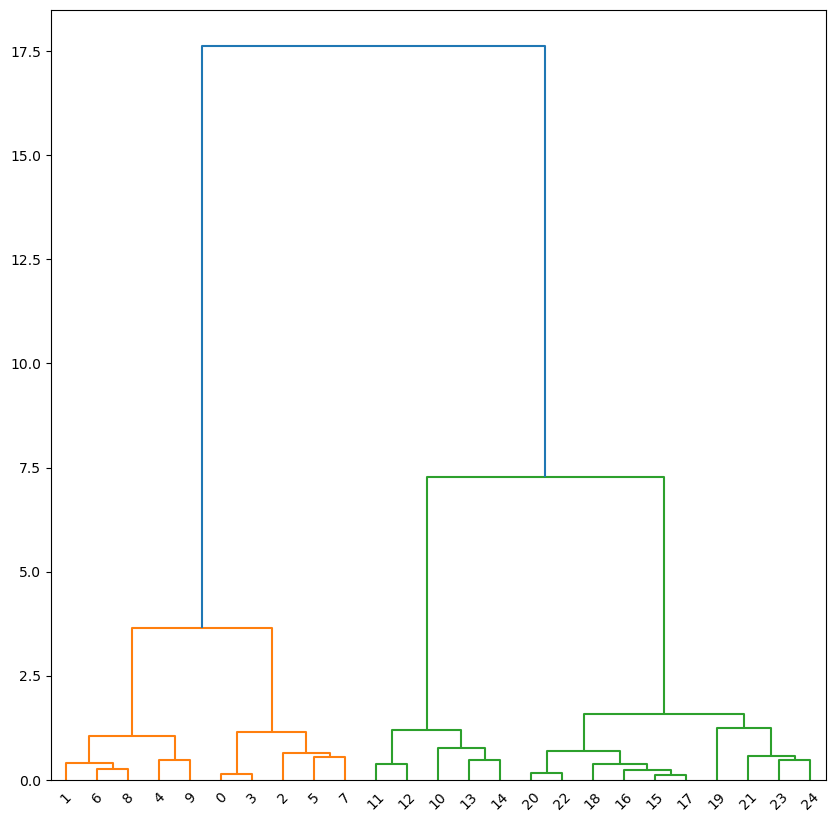

In [32]:
linkage_array=ward(X)

plt.figure(figsize=(10,10))
dendrogram(linkage_array)
plt.show()

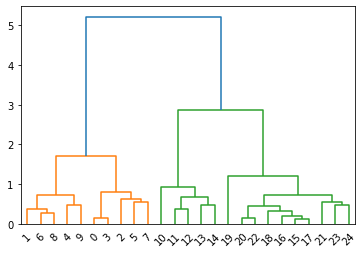

In [34]:
linkage_array=average(X)
dendrogram(linkage_array)
plt.show()

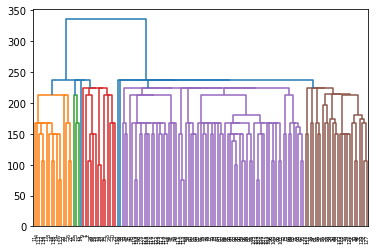

In [35]:
linkage_array=single(conc_data)
dendrogram(linkage_array)
plt.show()

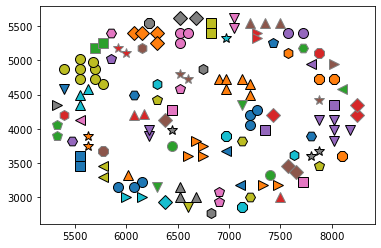

In [37]:
mglearn.discrete_scatter(conc_data['X1'],conc_data['X2'],fcluster(linkage_array,150,criterion='distance'))
plt.show()

**Exercise**: See what happens when you cluster the concentric circles with 'ward' or 'single' instead of average.

### Part 4: DBSCAN

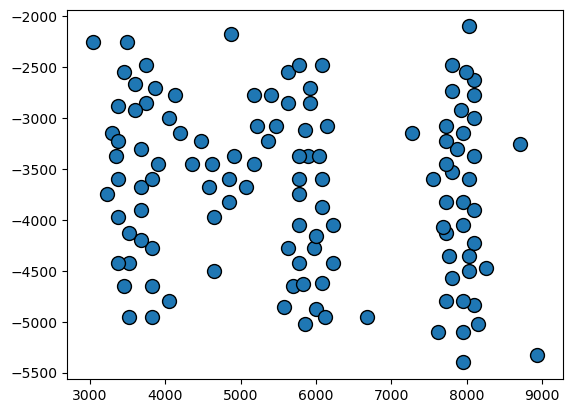

Number of points:  119


In [31]:
midata = pd.read_csv("MI-labeled.txt", sep=',')
features = np.array(midata[['X1','X2']])
mglearn.discrete_scatter(features[:,0],features[:,1])
plt.show()

print("Number of points: ", midata.shape[0])

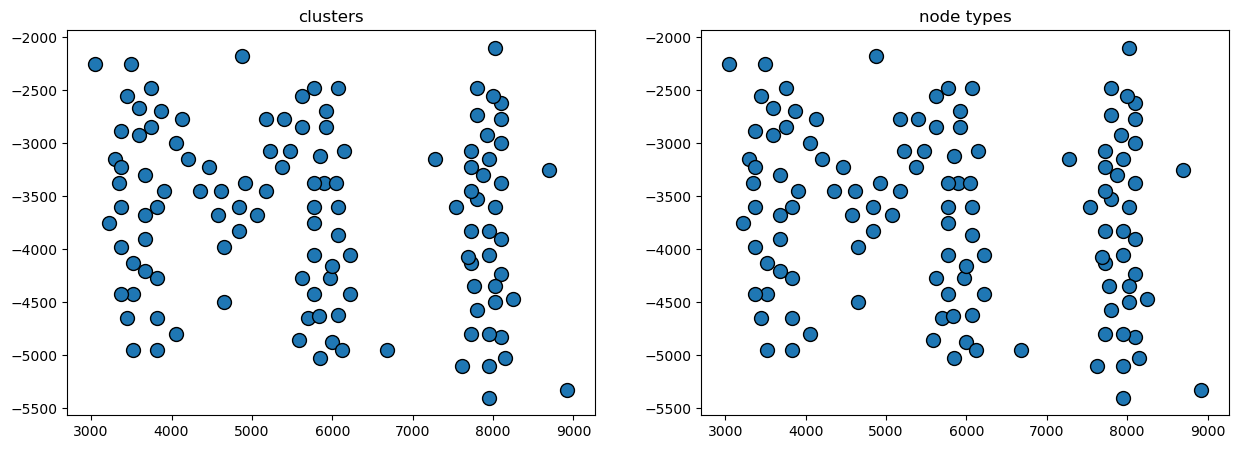

Number of core points: 119
Number of border points: 0
Number of isolated points: 0


In [57]:
k=4
epsilon = 1000

dbscan=DBSCAN(eps=epsilon,min_samples=k).fit(features)
fig,axes = plt.subplots(1,2,figsize=(15,5))

types=np.zeros(features.shape[0])
types[np.isin(np.arange(0,features.shape[0]),dbscan.core_sample_indices_)]=1
types[dbscan.labels_ == -1]= -1

mglearn.discrete_scatter(features[:,0],features[:,1],dbscan.labels_,ax=axes[0])
mglearn.discrete_scatter(features[:,0],features[:,1],types,ax=axes[1])
axes[0].set_title('clusters')
axes[1].set_title('node types')
plt.show()

print("Number of core points: {}".format(len(np.where(dbscan.labels_==0)[0])))
print("Number of border points: {}".format(len(np.where(dbscan.labels_==1)[0])))
print("Number of isolated points: {}".format(len(np.where(dbscan.labels_==-1)[0])))

In [54]:
np.where(dbscan.labels_==0)[0]

array([], dtype=int64)

In [45]:
dbscan.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

We can make a more informed choice for `eps` by considering the distribution of pairwise distances in the data:

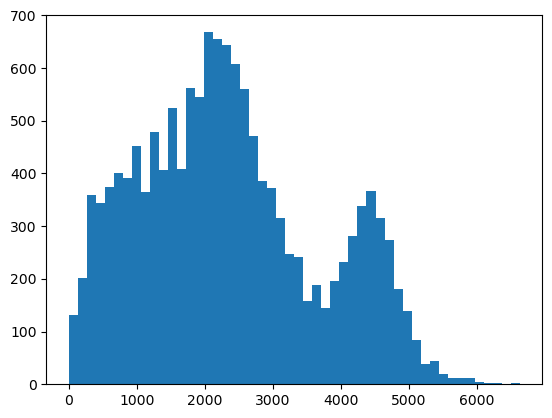

In [39]:
dmatrix = euclidean_distances(features)

plt.hist(dmatrix.ravel(),bins=50)
plt.show()

Close-up of the leftmost part:

Number of pairs of datapoints:  14161
Number of direct connections needed so that every point can be a core point for k = 4 : 476


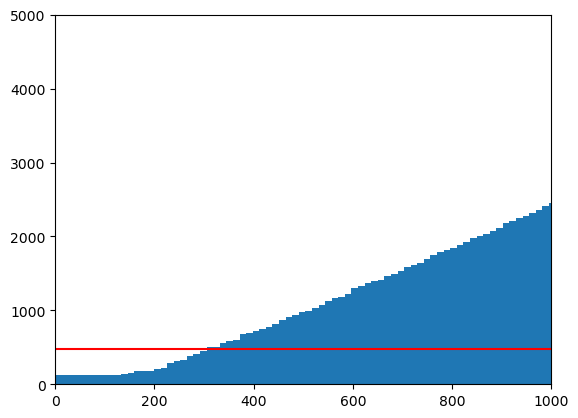

In [42]:
print("Number of pairs of datapoints: ",dmatrix.size)

print("Number of direct connections needed so that every point can be a core point for k = {} : {}".format(k,midata.shape[0]*k))

plt.xlim((0,1000))
plt.ylim((0,5000))
plt.hist(dmatrix.ravel(),bins=500,cumulative=True)
plt.axhline(y=midata.shape[0]*k,c='red')
plt.show()

### Clustering Evaluation

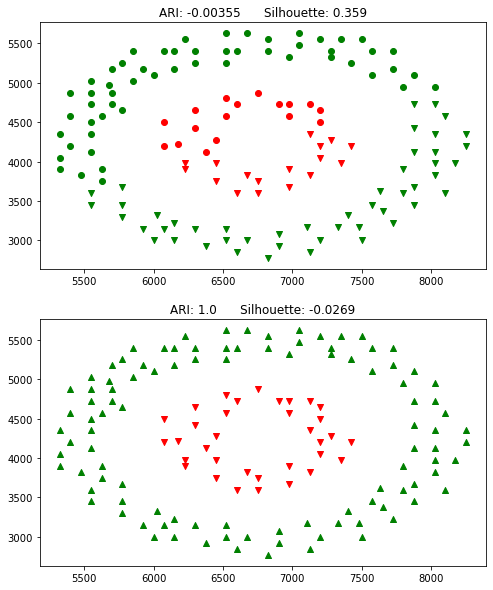

In [42]:
conc_kmeans = KMeans(n_clusters=2,n_init=1).fit(conc_data).labels_
conc_hier = fcluster(single(conc),300,criterion='distance')

clusterings = [conc_kmeans,conc_hier]

fig, axes = plt.subplots(len(clusterings),1,figsize=(8,5*len(clusterings)))
for n,cl in zip(np.arange(len(clusterings)),clusterings):
    discrete_cs_scatter(conc['X1'],conc['X2'],conc['Class'],cl,axis=axes[n])
    axes[n].set_title("ARI: {:.3}      Silhouette: {:.3}".format(adjusted_rand_score(conc['Class'],cl),silhouette_score(conc_data,cl)))

ARI and Silhouette coefficients give very conflicting evaluations: clustering with perfect ARI = 1.0 has very bad (negative) Silhouette coefficient (points closer to other clusters, than to own cluster center). Clustering with much better Silhouette coefficient, has awful ARI (negative: worse than expected from a random clustering).

Investigating number of clusters with silhouette coefficient

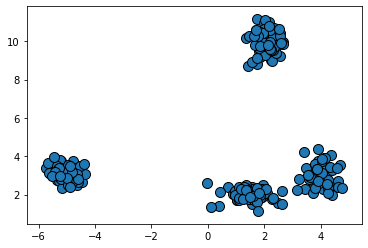

In [43]:
means=np.array([[-5,3],[4,3],[1.5,2],[2,10],[3,5]])
covars=np.array([[0.1,0.2,0],[0.1,0.3,0],[.3,0.1,0],[0.1,0.3,0],[0.1,0.2,0]])
mixturecoeff=np.array([1,1,1,1])

np.random.seed(1)
GaussMix_data, GaussMix_label = sample_mix2d_gaussians(250,mixturecoeff,means,covars)

mglearn.discrete_scatter(GaussMix_data[:,0],GaussMix_data[:,1])
plt.show()

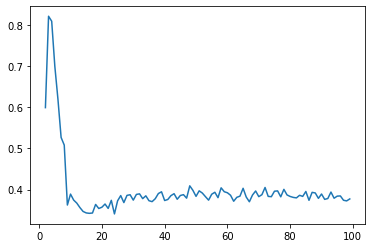

In [44]:

krange=np.arange(2,100,1)
silhouette=np.zeros(len(krange))

for k in krange:
    kmclus = KMeans(n_clusters=k,n_init=3).fit(GaussMix_data).labels_
    silhouette[k-2]= silhouette_score(GaussMix_data,kmclus) 
    
plt.plot(krange,silhouette)
plt.show()

Close-up at the first 10 k values:

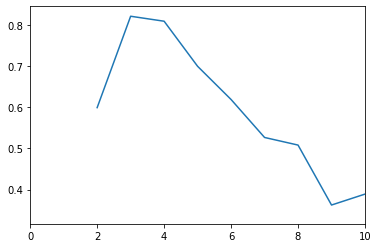

In [45]:
plt.xlim((0,10))
plt.plot(krange,silhouette)
plt.show()

Compare this to the silhouette coefficients obtained when clustering a single Gaussian (i.e., there are no valid clusters):

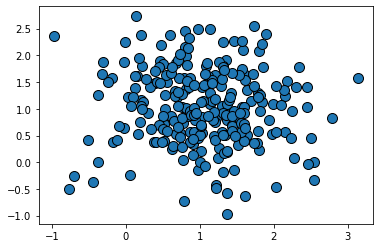

In [46]:
means=np.array([[1,1]])
covars=np.array([[0.5,0.5,0]])
mixturecoeff=np.array([1])

np.random.seed(1)
GaussMix_data, GaussMix_label = sample_mix2d_gaussians(250,mixturecoeff,means,covars)

mglearn.discrete_scatter(GaussMix_data[:,0],GaussMix_data[:,1])
plt.show()

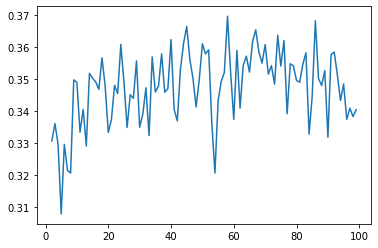

In [47]:
krange=np.arange(2,100,1)
silhouette=np.zeros(len(krange))

for k in krange:
    kmclus = KMeans(n_clusters=k,n_init=3).fit(GaussMix_data).labels_
    silhouette[k-2]= silhouette_score(GaussMix_data,kmclus) 
    
plt.plot(krange,silhouette)
plt.show()